In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.fft as fft
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import copy


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out




class FourierEncodingLayer(nn.Module):
    def __init__(self):
        super(FourierEncodingLayer, self).__init__()

    def forward(self, x):
        fourier_encoding = torch.fft.fftn(x, dim=(-2, -1))
        return fourier_encoding

class ZernikeEncodingLayer(nn.Module):
    def __init__(self, out_channels=25, max_order=8):
        super(ZernikeEncodingLayer, self).__init__()
        self.max_order = max_order
        self.out_channels = out_channels

    def forward(self, x):
        x_normalized = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
        if x.size(1) > 1:
            x_normalized = torch.mean(x_normalized, dim=1, keepdim=True)

        # Compute Zernike moments
        zernike_features = []
        for i in range(x_normalized.size(0)):
            image = x_normalized[i, 0, :, :].detach().cpu().numpy()  # Detach from computation graph
            moments = zernike_moments(image, radius=8, degree=self.max_order)
            moments = adjust_channels(moments, self.out_channels)
            zernike_features.append(moments.flatten())
        zernike_features = torch.tensor(zernike_features).to(x.device)

        return zernike_features
    
def adjust_channels(moments, output_channels):
    """
    Adjust the number of channels in the Zernike moments array to match the desired number of output channels.

    Parameters:
        moments (ndarray): Array containing Zernike moments.
        output_channels (int): Desired number of output channels.

    Returns:
        ndarray: Adjusted Zernike moments array with the desired number of output channels.
    """
    num_channels = moments.shape[0]
    if num_channels == output_channels:
        return moments  # No adjustment needed

    # If the number of channels is less than the desired output channels, repeat the existing channels
    if num_channels < output_channels:
        repetitions = output_channels // num_channels
        residual_channels = output_channels % num_channels
        adjusted_moments = np.repeat(moments, repetitions, axis=0)
        if residual_channels > 0:
            adjusted_moments = np.concatenate((adjusted_moments, moments[:residual_channels]), axis=0)
        return adjusted_moments

    # If the number of channels is greater than the desired output channels, reduce the number of channels
    if num_channels > output_channels:
        return moments[:output_channels]


def znl(Da, Aa, Pa, n, l):
    """
    Compute Zernike polynomial at (n,l).

    Parameters:
        Da (ndarray): Array of distances.
        Aa (ndarray): Array of complex values.
        Pa (ndarray): Array of weights.
        n (int): Radial degree of the Zernike polynomial.
        l (int): Azimuthal order of the Zernike polynomial.

    Returns:
        complex: Resulting Zernike polynomial value.
    """
    pi = np.pi
    v = 0.0 + 0.0j
    for d, a, p in zip(Da, Aa, Pa):
        Vnl = 0.0 + 0.0j
        g_m = [((-1) ** m * np.math.factorial(n - m)) /
               (np.math.factorial(m) * np.math.factorial((n - 2 * m + l) // 2) * np.math.factorial((n - 2 * m - l) // 2))
               for m in range((n - l) // 2 + 1)]
        for m in range((n - l) // 2 + 1):
            Vnl += g_m[m] * (d ** (n - 2 * m)) * a
        v += p * np.conj(Vnl)
    v *= (n + 1) / pi
    return v

def center_of_mass(image):
    """
    Compute the center of mass of the image.

    Parameters:
        image (ndarray): Input image.

    Returns:
        tuple: Center of mass coordinates.
    """
    height, width = image.shape
    row, col = np.indices((height, width))
    total_mass = np.sum(image)
    row_cm = np.sum(row * image) / total_mass
    col_cm = np.sum(col * image) / total_mass
    return row_cm, col_cm

def zernike_moments(im, radius, degree=8):
    """
    Compute Zernike moments for the image 'im'.

    Parameters:
        im (ndarray): Input image.
        radius (int): Maximum radius for the Zernike polynomials, in pixels.
        degree (int): Maximum degree to use (default: 8).

    Returns:
        ndarray: Zernike moments.
    """
    zvalues = []
    cm = center_of_mass(im)
    c0, c1 = cm

    Y, X = np.mgrid[:im.shape[0], :im.shape[1]]
    P = im.ravel()

    def rescale(C, centre):
        Cn = C.astype(np.double)
        Cn -= centre
        Cn /= radius
        return Cn.ravel()

    Yn = rescale(Y, c0)
    Xn = rescale(X, c1)

    Dn = Xn**2
    Dn += Yn**2
    np.sqrt(Dn, Dn)
    np.maximum(Dn, 1e-9, out=Dn)
    k = (Dn <= 1.)
    k &= (P > 0)

    frac_center = np.array(P[k], np.double)
    frac_center = frac_center.ravel()
    frac_center /= frac_center.sum()
    Yn = Yn[k]
    Xn = Xn[k]
    Dn = Dn[k]
    An = np.empty(Yn.shape, np.complex_)
    An.real = (Xn/Dn)
    An.imag = (Yn/Dn)

    Ans = [An**p for p in range(2, degree+2)]
    Ans.insert(0, An)  # An**1
    Ans.insert(0, np.ones_like(An))  # An**0
    for n in range(degree+1):
        for l in range(n+1):
            if (n-l) % 2 == 0:
                z = znl(Dn, Ans[l], frac_center, n, l)
                zvalues.append(abs(z))
    return np.array(zvalues)


class ResNetEncoder(nn.Module):
    def __init__(self, block, layers, num_classes, use_global_pooling=True, use_fourier_encoding=False, use_laplacian_encoding=False, use_zernike_encoding=False, max_zernike_order=8):
        super(ResNetEncoder, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layers = nn.ModuleList()
        for i, layer_blocks in enumerate(layers):
            stride = 2 if i > 0 else 1
            res_block = self.make_layer(block, 64 * (2 ** i), layer_blocks, stride)
            self.layers.append(res_block)

        self.use_global_pooling = use_global_pooling
        self.use_fourier_encoding = use_fourier_encoding
        self.use_laplacian_encoding = use_laplacian_encoding
        self.use_zernike_encoding = use_zernike_encoding

        if use_global_pooling:
            self.global_pool = nn.AdaptiveAvgPool2d(1)

        if use_fourier_encoding:
            self.fourier_encoding_layer = FourierEncodingLayer()

        if use_laplacian_encoding:
            self.laplacian_filter = torch.Tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]])
            self.laplacian_filter = self.laplacian_filter.repeat(64 * (2 ** (len(layers) - 1)), 1, 1, 1)

        if use_zernike_encoding:
            self.zernike_encoding_layer = ZernikeEncodingLayer(64 * (2 ** (len(layers) - 1)), max_zernike_order)

        # Compute the size of the fully connected layer dynamically
        fc_input_size = 64 * (2 ** (len(layers) - 1))
        if not use_global_pooling:
            fc_input_size *= 4 * 4


        self.fc = nn.Linear(fc_input_size, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for layer in self.layers:
            x = layer(x)

        if self.use_fourier_encoding:
            fourier_encoding = self.fourier_encoding_layer(x)
            x = x + fourier_encoding.real

        if self.use_laplacian_encoding:
            laplacian_encoding = F.conv2d(x, self.laplacian_filter.to(x.device), groups=x.size(1), padding=1)
            x = x + laplacian_encoding
            
        if self.use_zernike_encoding:
            zernike_features = self.zernike_encoding_layer(x)
            zernike_features = zernike_features.unsqueeze(2).unsqueeze(3)
            x = torch.cat((x, zernike_features), dim=1)

        if self.use_global_pooling:
            x = self.global_pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

    def train_model(self, train_dataset, validation_ratio=0.2, learning_rate=0.001, batch_size=32, epochs=20, weight_decay=1e-4, max_epochs_no_improve=6, max_grad_norm=None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        # Split dataset into train and validation sets
        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(validation_ratio * num_train))
        np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)


        # Results dictionary to store training and validation results
        training_results = {'train_accuracy': [], 'train_loss': [], 'val_accuracy': [], 'val_loss': []}

        best_model_weights = copy.deepcopy(self.state_dict())
        best_val_loss = float('inf')
        epochs_no_improve = 0

        # Training loop
        for epoch in range(epochs):
            self.train()
            total_loss = 0
            correct_predictions = 0
            total_samples = 0

            # Training phase
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()

                # Gradient clipping if max_grad_norm is specified
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), max_grad_norm)

                optimizer.step()

                total_loss += loss.item()

                # Calculate training accuracy
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            average_loss = total_loss / len(train_loader)
            accuracy = correct_predictions / total_samples * 100.0

            # Store training results
            training_results['train_accuracy'].append(accuracy)
            training_results['train_loss'].append(average_loss)

            # Validation phase
            self.eval()  # Set model to evaluation mode

            val_loss = 0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_outputs = self(val_inputs)
                    val_loss_batch = criterion(val_outputs, val_labels)
                    val_loss += val_loss_batch.item()

                    # Calculate validation accuracy
                    _, val_predicted = torch.max(val_outputs, 1)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()
                    val_total_samples += val_labels.size(0)

            val_average_loss = val_loss / len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples * 100.0

            # Store validation results
            training_results['val_accuracy'].append(val_accuracy)
            training_results['val_loss'].append(val_average_loss)

            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.2f}%, Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            lr_scheduler.step(val_average_loss)

            # Early stopping based on validation loss
            if val_average_loss < best_val_loss:
                best_val_loss = val_average_loss
                best_model_weights = copy.deepcopy(self.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= max_epochs_no_improve:
                    print(f"No improvement in validation loss for {epochs_no_improve} epochs. Early stopping...")
                    break

        # Load the best model weights
        self.load_state_dict(best_model_weights)

        # Save the trained model
        torch.save(self.state_dict(), 'trained_model_with_validation.pth')

        return training_results

        
    def test_model(self, test_dataset, batch_size):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        
        self.eval() 

        correct_predictions = 0
        total_samples = 0

        test_results = {'test_accuracy': []}
        confusion_labels = []
        confusion_predictions = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)

                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

                confusion_labels.extend(labels.cpu().numpy())
                confusion_predictions.extend(predicted.cpu().numpy())


        # Calculate and store test accuracy
        test_accuracy = correct_predictions / total_samples * 100.0
        test_results['test_accuracy'].append(test_accuracy)

        # Generate and plot the confusion matrix
        confusion_mat = confusion_matrix(confusion_labels, confusion_predictions)
        class_names = [f'Class {i}' for i in range(3)]

        plt.figure(figsize=(5, 5))
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        return test_results

In [2]:
import torch.nn.init as init
import random
import numpy as np

def initialize_weights(model, seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed)
    random.seed(seed)

    # Initialize the model's weights
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.xavier_uniform_(m.weight, gain=init.calculate_gain('relu'))
            if m.bias is not None:
                init.constant_(m.bias, 0)


In [3]:
resnet_model_without_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_global_pooling=False)
initialize_weights(resnet_model_without_pooling)

resnet_model_with_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3)
initialize_weights(resnet_model_with_pooling)


In [4]:
import os
from shutil import copyfile

def create_train_test_sets(tx):
    # Set paths for train and test sets based on the translation value
    train_set_directory = f"/home/amine/equivariant-cnns/train_set_{tx}"
    test_set_directory = f"/home/amine/equivariant-cnns/test_set_{tx}"

    # Check if train and test directories already exist
    if os.path.exists(train_set_directory) and os.path.exists(test_set_directory):
        print("Train and test directories already exist.")
        return train_set_directory, test_set_directory

    # Create train and test directories
    os.makedirs(train_set_directory, exist_ok=True)
    os.makedirs(test_set_directory, exist_ok=True)

    categories = [17, 18, 19]
    for category_id in categories:
        category_directory = os.path.join(f"/home/amine/equivariant-cnns/translated_image_{tx}/", f"category_{category_id}")

        # Create folders for each category in training and testing sets
        train_category_directory = os.path.join(train_set_directory, f"category_{category_id}")
        test_category_directory = os.path.join(test_set_directory, f"category_{category_id}")

        os.makedirs(train_category_directory, exist_ok=True)
        os.makedirs(test_category_directory, exist_ok=True)

        images = os.listdir(category_directory)
        random.shuffle(images)

        split_ratio = 0.8
        split_index = int(len(images) * split_ratio)

        # Copy images to the train set
        for img in images[:split_index]:
            src_path = os.path.join(category_directory, img)
            dst_path = os.path.join(train_category_directory, img)
            copyfile(src_path, dst_path)

        # Copy images to the test set
        for img in images[split_index:]:
            src_path = os.path.join(category_directory, img)
            dst_path = os.path.join(test_category_directory, img)
            copyfile(src_path, dst_path)

    return train_set_directory, test_set_directory

In [7]:
from data_loader.dataset import CustomDataset

train_set_directory, test_set_directory = create_train_test_sets(10)

train_dataset_10 = CustomDataset(root=train_set_directory)
test_dataset_10 = CustomDataset(root=test_set_directory)

Train and test directories already exist.


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
0
NVIDIA GeForce RTX 2080 Ti


In [10]:

learning_rate = 0.001
batch_size = 32
epochs = 20
validation_ratio=0.2

pooling_results_10 = resnet_model_with_pooling.train_model(train_dataset_10, validation_ratio, learning_rate, batch_size, epochs)
no_pooling_results_10 = resnet_model_without_pooling.train_model(train_dataset_10, validation_ratio, learning_rate, batch_size, epochs)

pooling_test_results = {}
pooling_test_results[10] = resnet_model_with_pooling.test_model(test_dataset_10, batch_size)
no_pooling_test_results = {}
no_pooling_test_results[10] = resnet_model_without_pooling.test_model(test_dataset_10, batch_size)



Epoch 1/20, Train Loss: 1.0204, Train Accuracy: 53.06%, Val Loss: 1.1247, Val Accuracy: 47.99%
Epoch 2/20, Train Loss: 0.8630, Train Accuracy: 58.99%, Val Loss: 0.8905, Val Accuracy: 57.54%
Epoch 3/20, Train Loss: 0.8042, Train Accuracy: 62.51%, Val Loss: 0.7889, Val Accuracy: 63.09%
Epoch 4/20, Train Loss: 0.7687, Train Accuracy: 64.72%, Val Loss: 1.9084, Val Accuracy: 41.37%
Epoch 5/20, Train Loss: 0.7264, Train Accuracy: 66.73%, Val Loss: 0.8179, Val Accuracy: 62.61%
Epoch 6/20, Train Loss: 0.6768, Train Accuracy: 69.37%, Val Loss: 0.6571, Val Accuracy: 70.63%
Epoch 7/20, Train Loss: 0.6162, Train Accuracy: 72.51%, Val Loss: 0.6369, Val Accuracy: 70.35%
Epoch 8/20, Train Loss: 0.5649, Train Accuracy: 74.94%, Val Loss: 0.8502, Val Accuracy: 64.61%
Epoch 9/20, Train Loss: 0.4993, Train Accuracy: 78.12%, Val Loss: 0.5403, Val Accuracy: 76.92%
Epoch 10/20, Train Loss: 0.4275, Train Accuracy: 81.56%, Val Loss: 0.5297, Val Accuracy: 77.11%
Epoch 11/20, Train Loss: 0.3595, Train Accuracy: 

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (20,) and (6,)

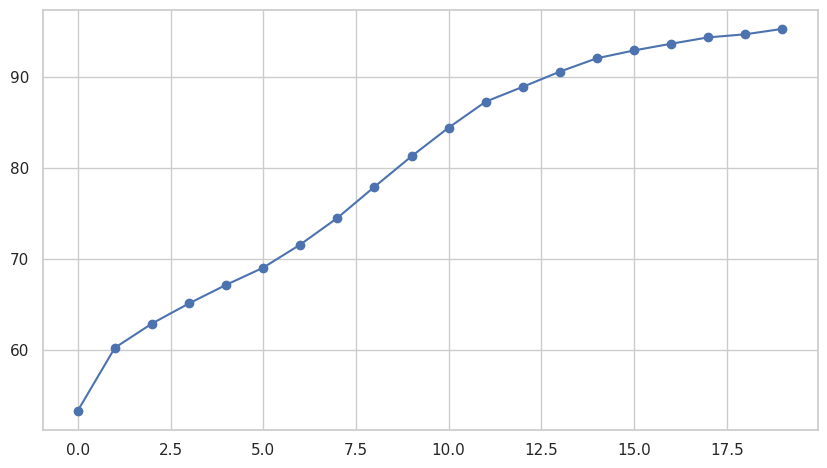

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))

# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), pooling_results_10['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_10['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), pooling_results_10['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_10['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import dill
dill.dump_session('session_state1.pkl')

Epoch 1/20, Average Loss: 0.9931, Accuracy: 52.95
Epoch 2/20, Average Loss: 0.8613, Accuracy: 59.83
Epoch 3/20, Average Loss: 0.7930, Accuracy: 63.43
Epoch 4/20, Average Loss: 0.7550, Accuracy: 65.62
Epoch 5/20, Average Loss: 0.7017, Accuracy: 68.14
Epoch 6/20, Average Loss: 0.6537, Accuracy: 70.71
Epoch 7/20, Average Loss: 0.6109, Accuracy: 72.81
Epoch 8/20, Average Loss: 0.5680, Accuracy: 74.66
Epoch 9/20, Average Loss: 0.5199, Accuracy: 77.02
Epoch 10/20, Average Loss: 0.4787, Accuracy: 78.98
Epoch 11/20, Average Loss: 0.4421, Accuracy: 80.83
Epoch 12/20, Average Loss: 0.4002, Accuracy: 82.98
Epoch 13/20, Average Loss: 0.3641, Accuracy: 84.58
Epoch 14/20, Average Loss: 0.3327, Accuracy: 85.99
Epoch 15/20, Average Loss: 0.3040, Accuracy: 87.09
Epoch 16/20, Average Loss: 0.2770, Accuracy: 88.51
Epoch 17/20, Average Loss: 0.2612, Accuracy: 89.27
Epoch 18/20, Average Loss: 0.2391, Accuracy: 90.17
Epoch 19/20, Average Loss: 0.2226, Accuracy: 90.98
Epoch 20/20, Average Loss: 0.2072, Accur

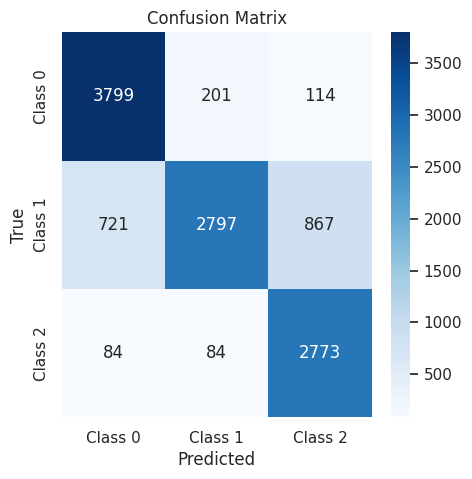

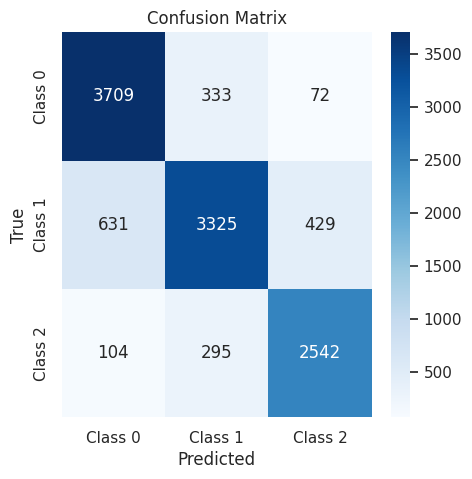

In [ ]:
from data_loader.dataset import CustomDataset

train_set_directory, test_set_directory = create_train_test_sets(30)

train_dataset_30 = CustomDataset(root=train_set_directory)
test_dataset_30 = CustomDataset(root=test_set_directory)

learning_rate = 0.001
batch_size = 32
epochs = 20



resnet_model_without_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_global_pooling=False)
initialize_weights(resnet_model_without_pooling)

resnet_model_with_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3)
initialize_weights(resnet_model_with_pooling)


pooling_results_30 = resnet_model_with_pooling.train_model(train_dataset_30, validation_ratio, learning_rate, batch_size, epochs)
no_pooling_results_30 = resnet_model_without_pooling.train_model(train_dataset_30, validation_ratio, learning_rate, batch_size, epochs)

pooling_test_results[30] = resnet_model_with_pooling.test_model(test_dataset_30, batch_size)
no_pooling_test_results[30] = resnet_model_without_pooling.test_model(test_dataset_30, batch_size)


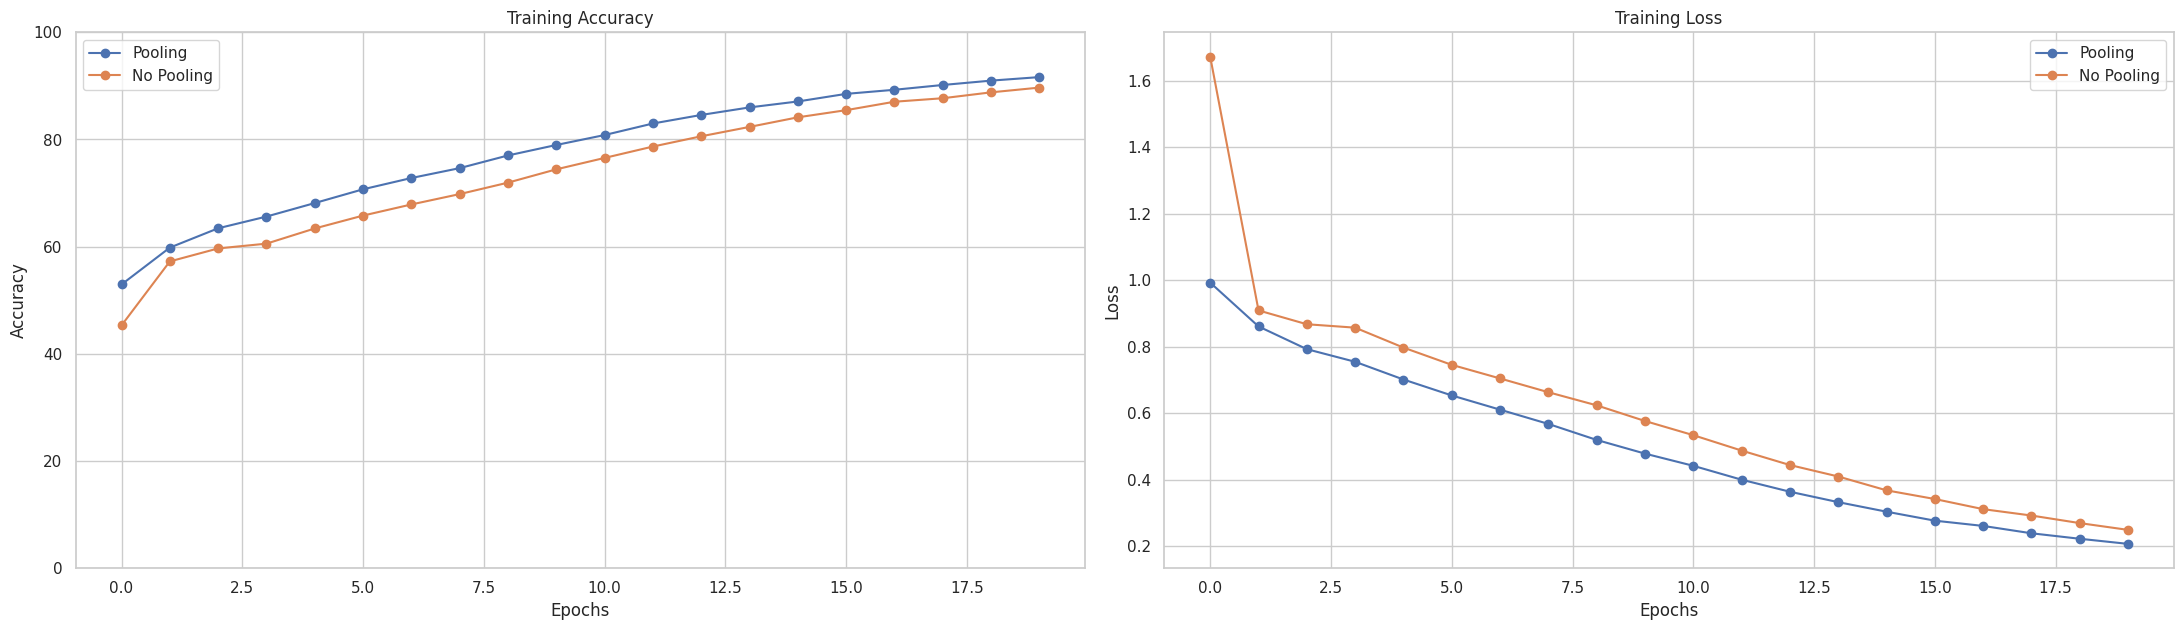

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), pooling_results_30['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_30['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), pooling_results_30['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_30['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dill.dump_session('session_state1.pkl')

Epoch 1/20, Average Loss: 1.0396, Accuracy: 51.78
Epoch 2/20, Average Loss: 0.8927, Accuracy: 57.55
Epoch 3/20, Average Loss: 0.8306, Accuracy: 61.25
Epoch 4/20, Average Loss: 0.7860, Accuracy: 63.98
Epoch 5/20, Average Loss: 0.7432, Accuracy: 65.56
Epoch 6/20, Average Loss: 0.6989, Accuracy: 68.09
Epoch 7/20, Average Loss: 0.6537, Accuracy: 70.50
Epoch 8/20, Average Loss: 0.6174, Accuracy: 72.08
Epoch 9/20, Average Loss: 0.5779, Accuracy: 74.10
Epoch 10/20, Average Loss: 0.5373, Accuracy: 76.11
Epoch 11/20, Average Loss: 0.4984, Accuracy: 77.95
Epoch 12/20, Average Loss: 0.4650, Accuracy: 79.84
Epoch 13/20, Average Loss: 0.4293, Accuracy: 81.51
Epoch 14/20, Average Loss: 0.3981, Accuracy: 82.79
Epoch 15/20, Average Loss: 0.3743, Accuracy: 83.92
Epoch 16/20, Average Loss: 0.3438, Accuracy: 85.34
Epoch 17/20, Average Loss: 0.3175, Accuracy: 86.54
Epoch 18/20, Average Loss: 0.3028, Accuracy: 87.32
Epoch 19/20, Average Loss: 0.2741, Accuracy: 88.51
Epoch 20/20, Average Loss: 0.2626, Accur

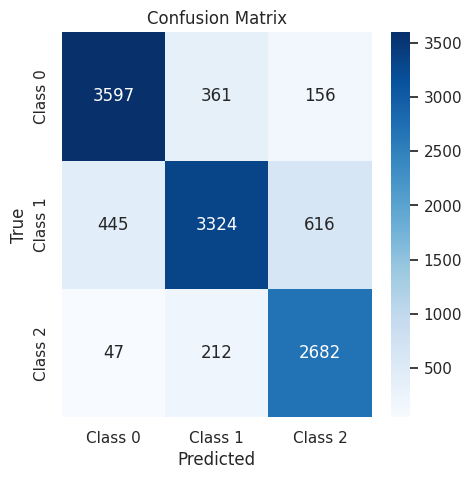

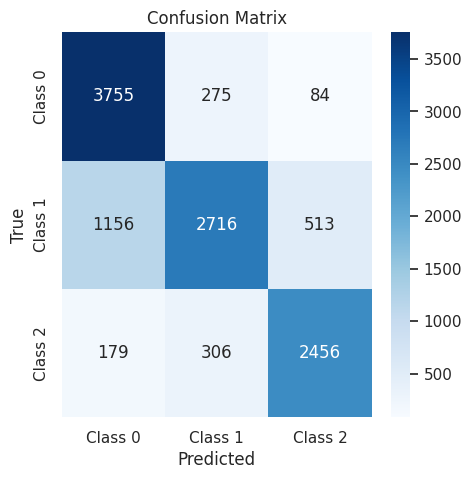

In [ ]:
from data_loader.dataset import CustomDataset

train_set_directory, test_set_directory = create_train_test_sets(50)

train_dataset_50 = CustomDataset(root=train_set_directory)
test_dataset_50 = CustomDataset(root=test_set_directory)

import seaborn as sns
import matplotlib.pyplot as plt

learning_rate = 0.001
batch_size = 32
epochs = 20

resnet_model_without_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_global_pooling=False)
initialize_weights(resnet_model_without_pooling)

resnet_model_with_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3)
initialize_weights(resnet_model_with_pooling)

pooling_results_50 = resnet_model_with_pooling.train_model(train_dataset_50, validation_ratio, learning_rate, batch_size, epochs)
no_pooling_results_50 = resnet_model_without_pooling.train_model(train_dataset_50, validation_ratio, learning_rate, batch_size, epochs)

pooling_test_results[50] = resnet_model_with_pooling.test_model(test_dataset_50, batch_size)
no_pooling_test_results[50] = resnet_model_without_pooling.test_model(test_dataset_50, batch_size)



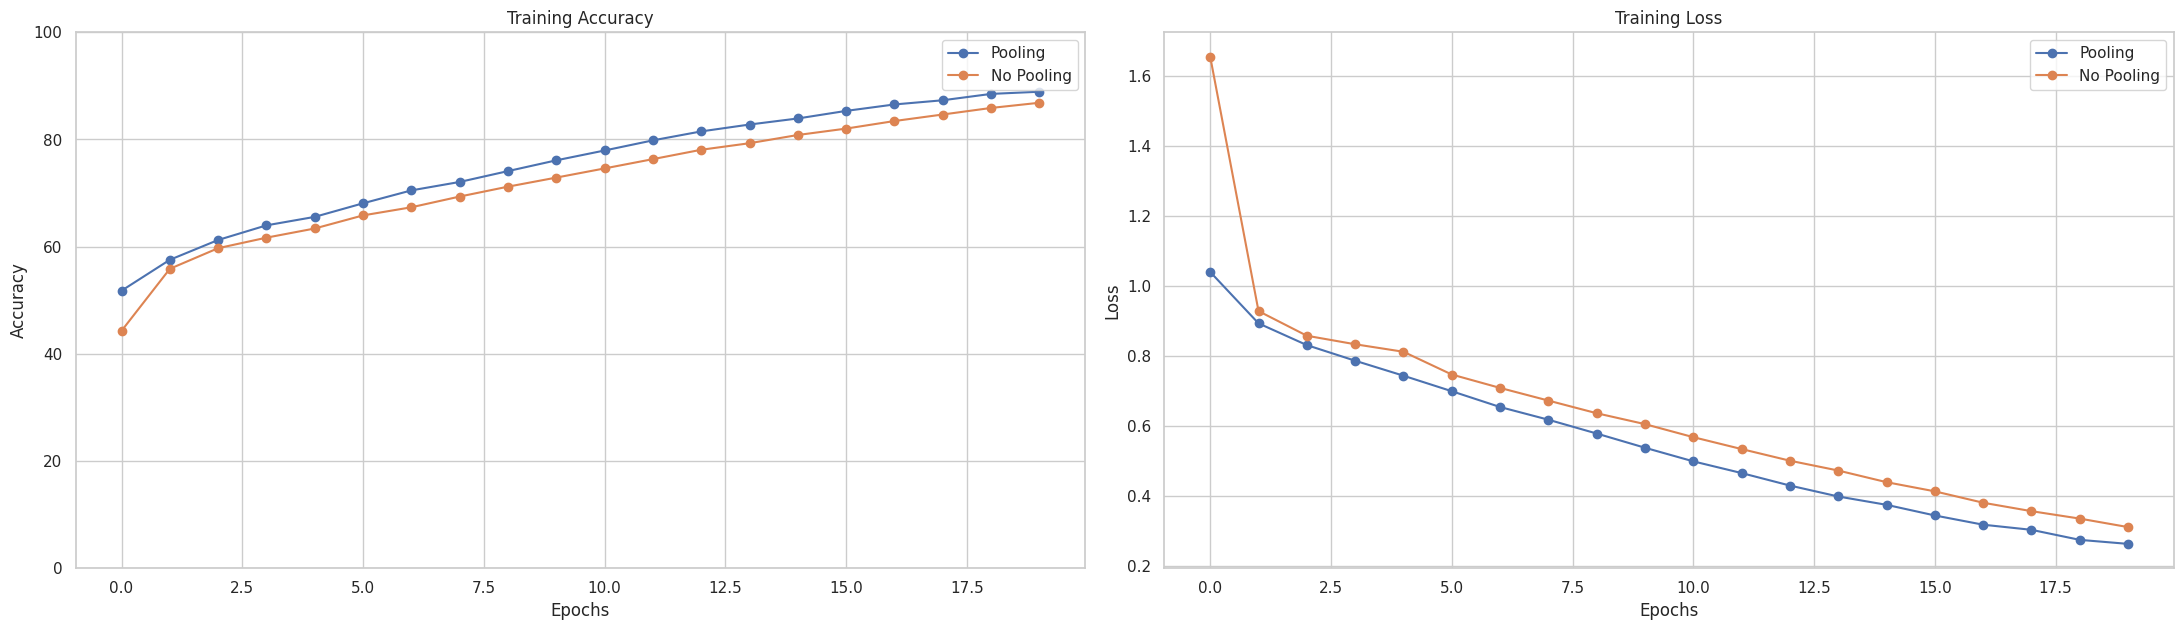

In [ ]:

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), pooling_results_50['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_50['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), pooling_results_50['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_50['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dill.dump_session('session_state1.pkl')

Epoch 1/20, Average Loss: 0.9880, Accuracy: 53.44
Epoch 2/20, Average Loss: 0.8385, Accuracy: 60.31
Epoch 3/20, Average Loss: 0.7897, Accuracy: 63.19
Epoch 4/20, Average Loss: 0.7475, Accuracy: 65.33
Epoch 5/20, Average Loss: 0.7062, Accuracy: 67.76
Epoch 6/20, Average Loss: 0.6576, Accuracy: 69.86
Epoch 7/20, Average Loss: 0.6118, Accuracy: 72.27
Epoch 8/20, Average Loss: 0.5671, Accuracy: 74.75
Epoch 9/20, Average Loss: 0.5243, Accuracy: 76.59
Epoch 10/20, Average Loss: 0.4802, Accuracy: 78.95
Epoch 11/20, Average Loss: 0.4381, Accuracy: 80.93
Epoch 12/20, Average Loss: 0.3952, Accuracy: 82.88
Epoch 13/20, Average Loss: 0.3585, Accuracy: 84.69
Epoch 14/20, Average Loss: 0.3306, Accuracy: 85.97
Epoch 15/20, Average Loss: 0.2989, Accuracy: 87.42
Epoch 16/20, Average Loss: 0.2774, Accuracy: 88.34
Epoch 17/20, Average Loss: 0.2536, Accuracy: 89.48
Epoch 18/20, Average Loss: 0.2416, Accuracy: 90.05
Epoch 19/20, Average Loss: 0.2208, Accuracy: 90.83
Epoch 20/20, Average Loss: 0.2124, Accur

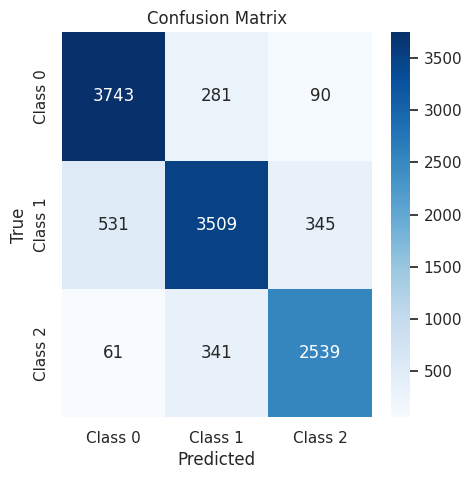

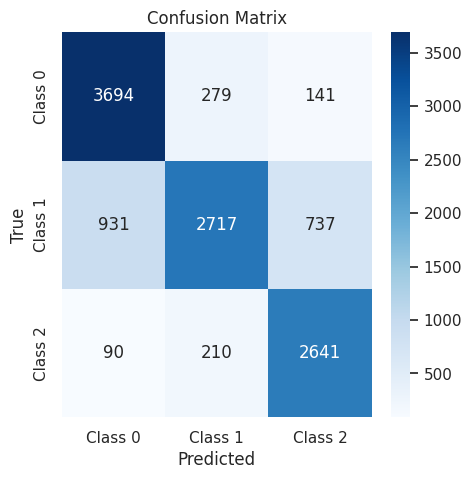

In [ ]:
from data_loader.dataset import CustomDataset

train_set_directory, test_set_directory = create_train_test_sets(70)

train_dataset_70 = CustomDataset(root=train_set_directory)
test_dataset_70 = CustomDataset(root=test_set_directory)

import seaborn as sns
import matplotlib.pyplot as plt

learning_rate = 0.001
batch_size = 32
epochs = 20


resnet_model_without_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_global_pooling=False)
initialize_weights(resnet_model_without_pooling)

resnet_model_with_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3)
initialize_weights(resnet_model_with_pooling)

pooling_results_70 = resnet_model_with_pooling.train_model(train_dataset_70, validation_ratio, learning_rate, batch_size, epochs)
no_pooling_results_70 = resnet_model_without_pooling.train_model(train_dataset_70, validation_ratio, learning_rate, batch_size, epochs)

pooling_test_results[70] = resnet_model_with_pooling.test_model(test_dataset_70, batch_size)
no_pooling_test_results[70] = resnet_model_without_pooling.test_model(test_dataset_70, batch_size)



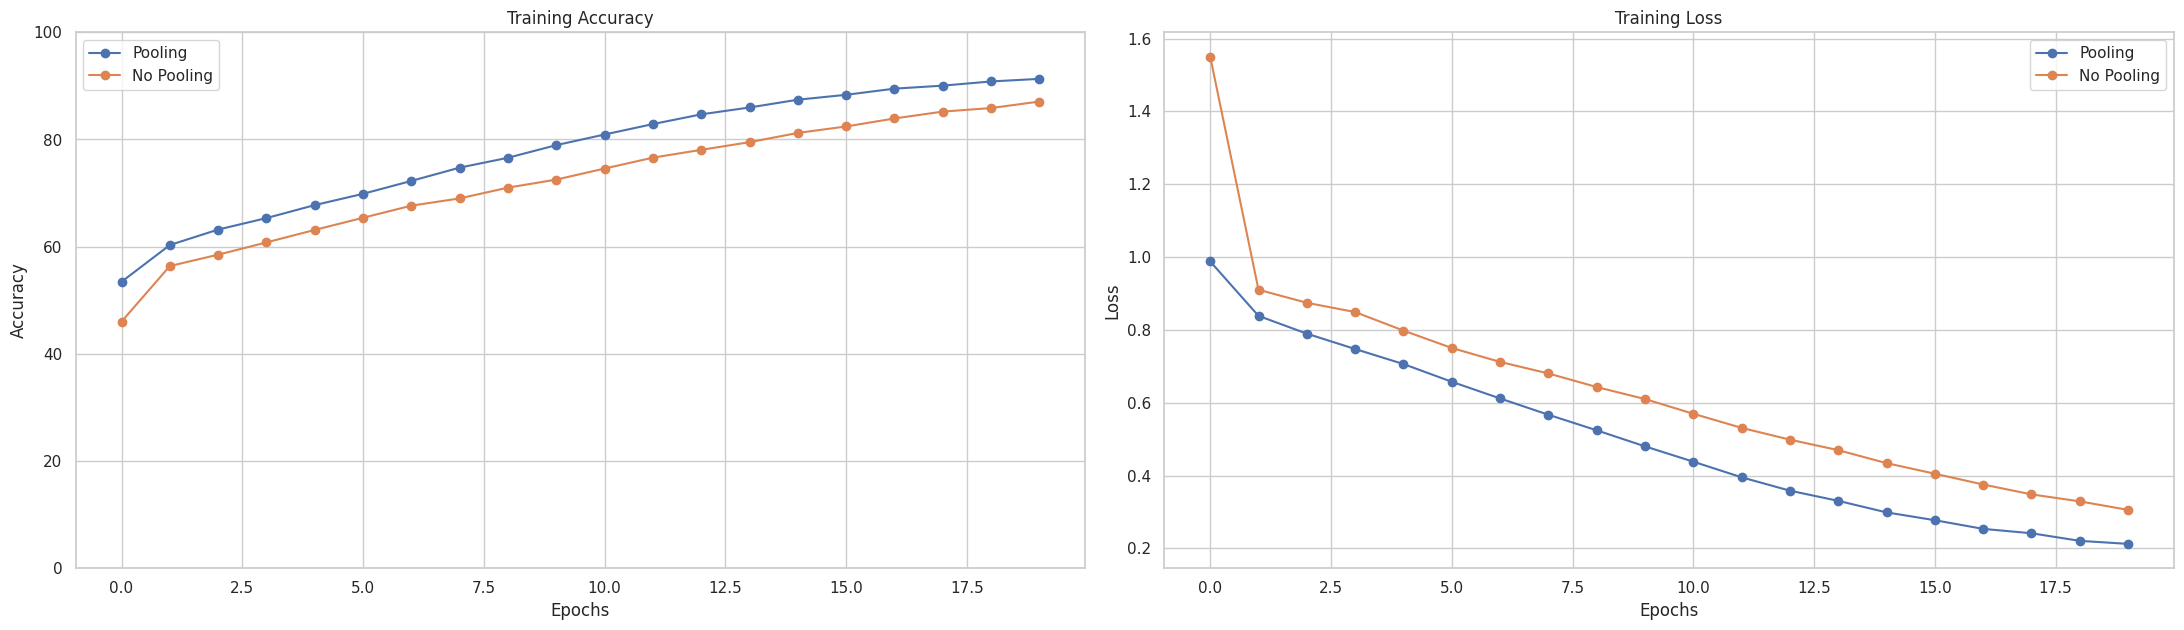

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), pooling_results_70['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_70['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), pooling_results_70['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_70['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dill.dump_session('session_state1.pkl')

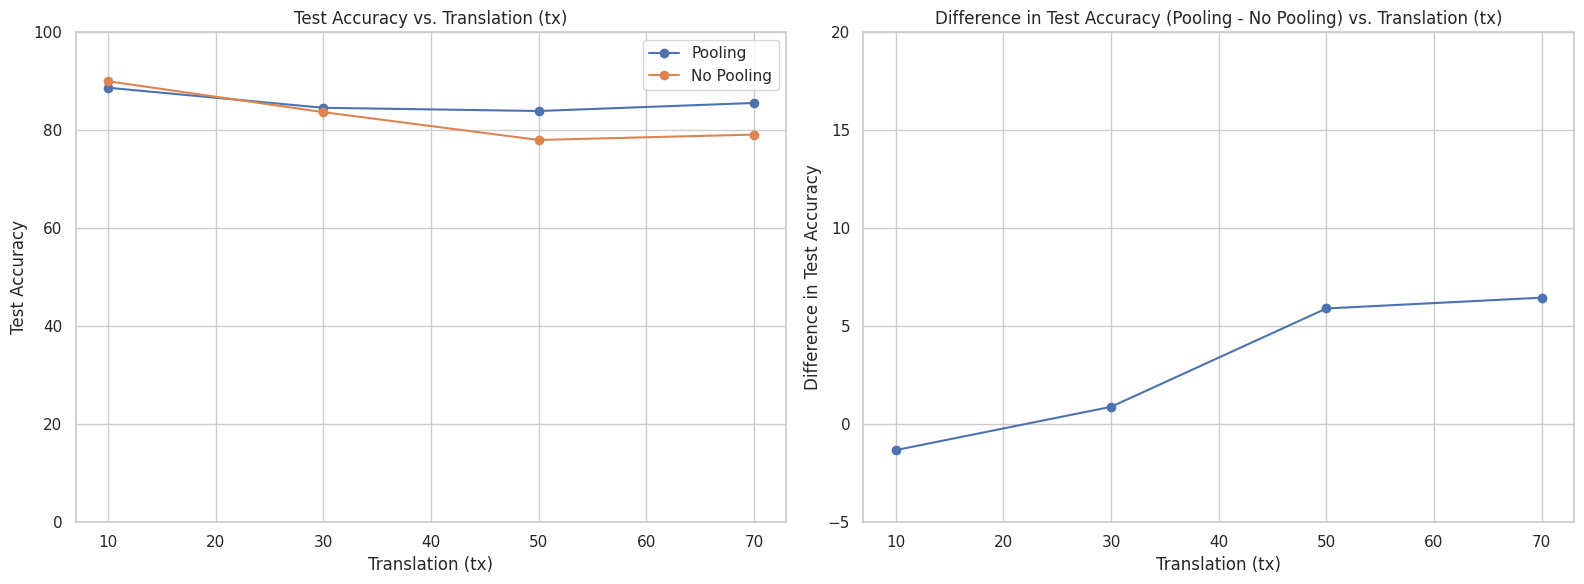

In [ ]:
# Define translation values
tx_values = [10, 30, 50, 70]

# Plotting
plt.figure(figsize=(16, 6))

# Plot Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(tx_values, [pooling_test_results[tx]['test_accuracy'][0] for tx in tx_values], label='Pooling', marker='o')
plt.plot(tx_values, [no_pooling_test_results[tx]['test_accuracy'][0] for tx in tx_values], label='No Pooling', marker='o')
plt.title('Test Accuracy vs. Translation (tx)')
plt.xlabel('Translation (tx)')
plt.ylabel('Test Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot the difference in Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(tx_values, np.array([pooling_test_results[tx]['test_accuracy'][0] for tx in tx_values]) - 
         np.array([no_pooling_test_results[tx]['test_accuracy'][0] for tx in tx_values]), marker='o')
plt.title('Difference in Test Accuracy (Pooling - No Pooling) vs. Translation (tx)')
plt.xlabel('Translation (tx)')
plt.ylabel('Difference in Test Accuracy')
plt.ylim(-5, 20)
plt.tight_layout()
plt.show()


In [ ]:
pooling_test_results

{10: {'test_accuracy': [88.69755244755245]},
 30: {'test_accuracy': [84.59685314685315]},
 50: {'test_accuracy': [83.9423076923077]},
 70: {'test_accuracy': [85.58566433566433]}}

In [ ]:
no_pooling_test_results

{10: {'test_accuracy': [90.01748251748252]},
 30: {'test_accuracy': [83.7062937062937]},
 50: {'test_accuracy': [78.03321678321679]},
 70: {'test_accuracy': [79.12587412587413]}}

In [ ]:
resnet_model_withlaplacian = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_laplacian_encoding=True)
initialize_weights(resnet_model_withlaplacian)

Epoch 1/20, Average Loss: 0.9482, Accuracy: 52.67
Epoch 2/20, Average Loss: 0.8295, Accuracy: 59.91
Epoch 3/20, Average Loss: 0.7692, Accuracy: 64.23
Epoch 4/20, Average Loss: 0.7101, Accuracy: 67.55
Epoch 5/20, Average Loss: 0.6502, Accuracy: 70.87
Epoch 6/20, Average Loss: 0.5841, Accuracy: 74.19
Epoch 7/20, Average Loss: 0.5075, Accuracy: 77.88
Epoch 8/20, Average Loss: 0.4293, Accuracy: 81.59
Epoch 9/20, Average Loss: 0.3470, Accuracy: 85.48
Epoch 10/20, Average Loss: 0.2773, Accuracy: 88.70
Epoch 11/20, Average Loss: 0.2294, Accuracy: 90.87
Epoch 12/20, Average Loss: 0.1899, Accuracy: 92.67
Epoch 13/20, Average Loss: 0.1633, Accuracy: 93.78
Epoch 14/20, Average Loss: 0.1491, Accuracy: 94.32
Epoch 15/20, Average Loss: 0.1324, Accuracy: 95.11
Epoch 16/20, Average Loss: 0.1248, Accuracy: 95.32
Epoch 17/20, Average Loss: 0.1153, Accuracy: 95.85
Epoch 18/20, Average Loss: 0.1093, Accuracy: 95.96
Epoch 19/20, Average Loss: 0.0987, Accuracy: 96.41
Epoch 20/20, Average Loss: 0.1001, Accur

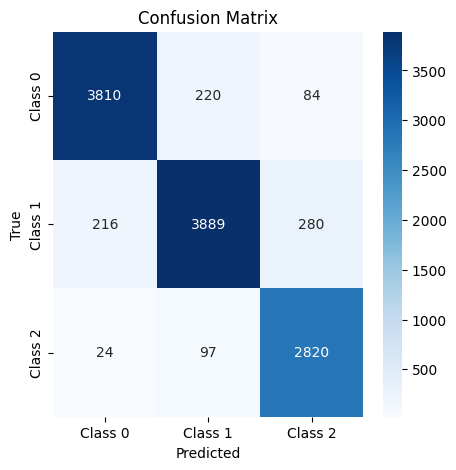

In [ ]:
laplacian_results_10 = resnet_model_withlaplacian.train_model(train_dataset_10, validation_ratio, learning_rate, batch_size, epochs)
laplacian_test_results = {}
laplacian_test_results[10] = resnet_model_withlaplacian.test_model(test_dataset_10, batch_size)

In [ ]:
dill.dump_session('session_state1.pkl')

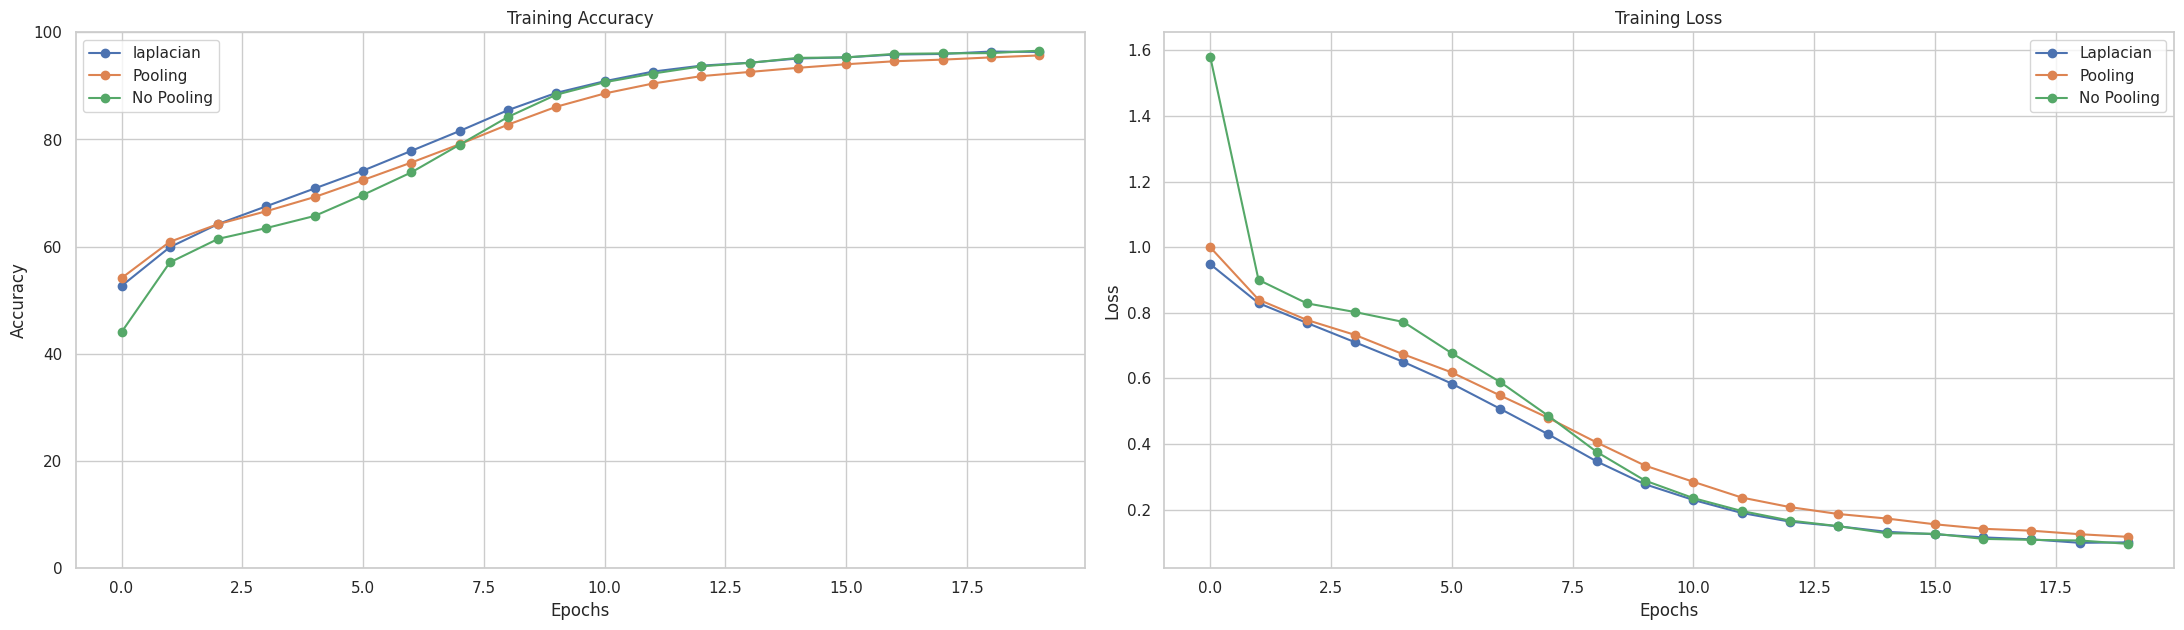

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), laplacian_results_10['train_accuracy'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_10['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_10['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), laplacian_results_10['train_loss'], label='Laplacian', marker='o')
plt.plot(range(epochs), pooling_results_10['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_10['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from data_loader.dataset import CustomDataset

train_set_directory, test_set_directory = create_train_test_sets(30)

train_dataset_30 = CustomDataset(root=train_set_directory)
test_dataset_30 = CustomDataset(root=test_set_directory)

Train and test directories already exist.


Epoch 1/20, Average Loss: 0.9377, Accuracy: 53.24
Epoch 2/20, Average Loss: 0.8334, Accuracy: 59.81
Epoch 3/20, Average Loss: 0.7963, Accuracy: 62.38
Epoch 4/20, Average Loss: 0.7459, Accuracy: 65.75
Epoch 5/20, Average Loss: 0.6871, Accuracy: 68.72
Epoch 6/20, Average Loss: 0.6414, Accuracy: 71.12
Epoch 7/20, Average Loss: 0.6007, Accuracy: 73.22
Epoch 8/20, Average Loss: 0.5628, Accuracy: 75.14
Epoch 9/20, Average Loss: 0.5198, Accuracy: 77.15
Epoch 10/20, Average Loss: 0.4821, Accuracy: 78.94
Epoch 11/20, Average Loss: 0.4402, Accuracy: 81.08
Epoch 12/20, Average Loss: 0.4038, Accuracy: 82.78
Epoch 13/20, Average Loss: 0.3737, Accuracy: 84.17
Epoch 14/20, Average Loss: 0.3382, Accuracy: 85.85
Epoch 15/20, Average Loss: 0.3122, Accuracy: 87.10
Epoch 16/20, Average Loss: 0.2876, Accuracy: 88.11
Epoch 17/20, Average Loss: 0.2649, Accuracy: 89.04
Epoch 18/20, Average Loss: 0.2488, Accuracy: 89.78
Epoch 19/20, Average Loss: 0.2255, Accuracy: 90.88
Epoch 20/20, Average Loss: 0.2167, Accur

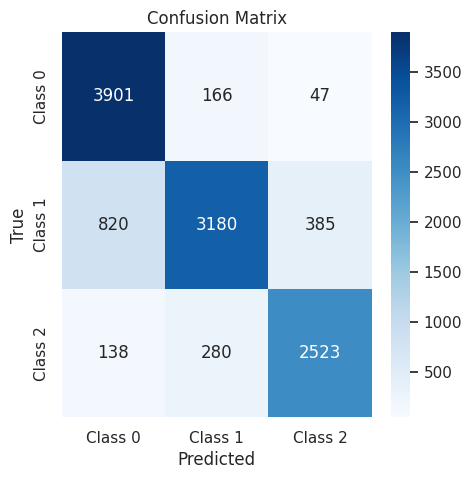

In [ ]:
resnet_model_withlaplacian = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_laplacian_encoding=True)
initialize_weights(resnet_model_withlaplacian)

laplacian_results_30 = resnet_model_withlaplacian.train_model(train_dataset_30, validation_ratio, learning_rate, batch_size, epochs)
laplacian_test_results[30] = resnet_model_withlaplacian.test_model(test_dataset_30, batch_size)

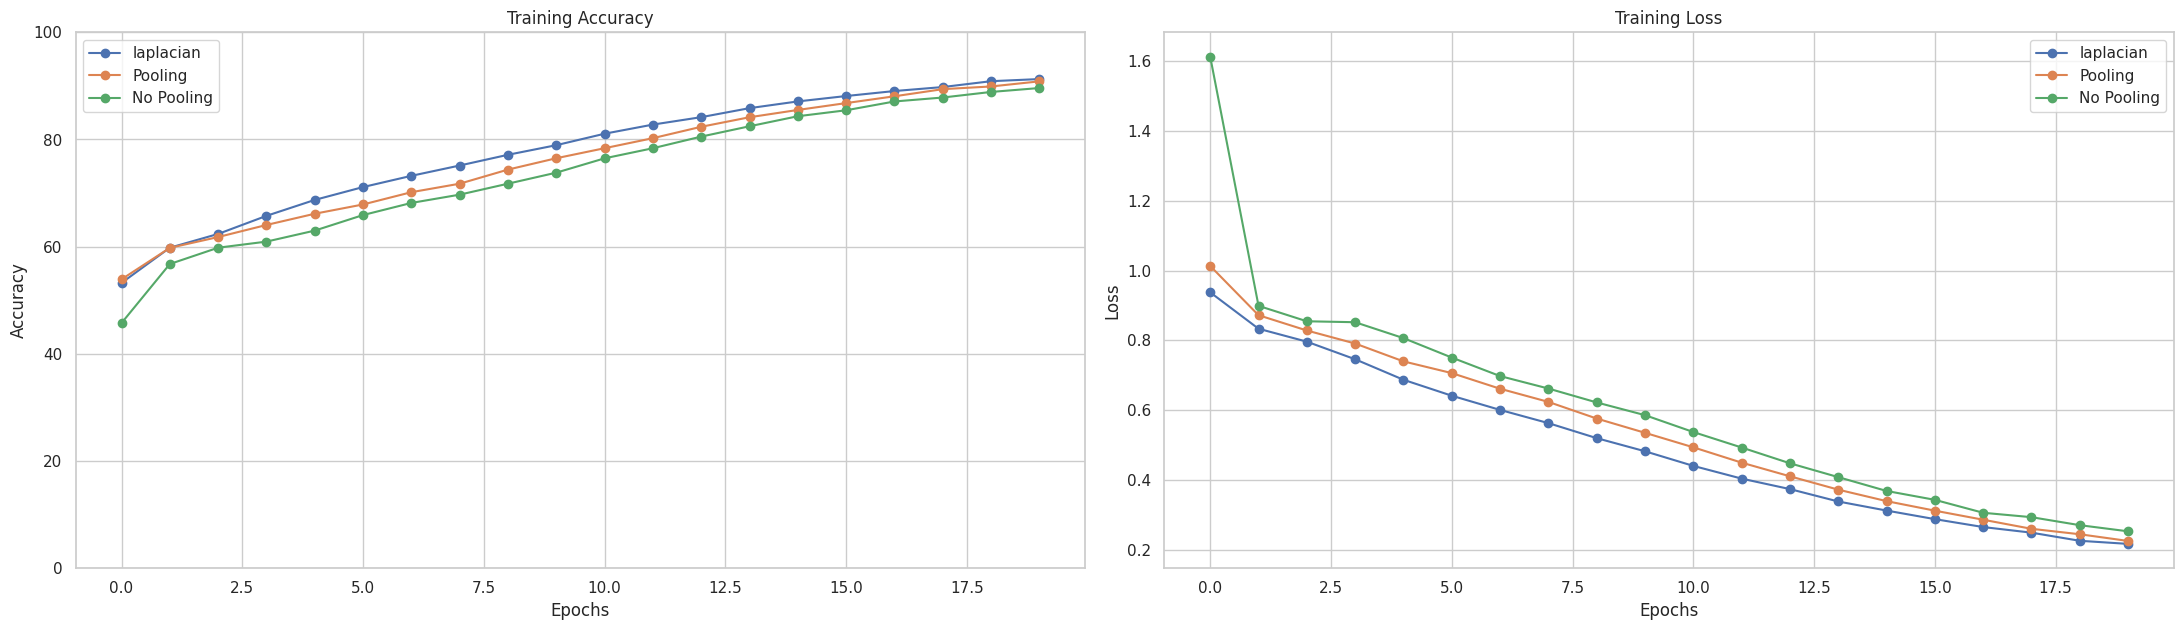

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), laplacian_results_30['train_accuracy'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_30['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_30['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), laplacian_results_30['train_loss'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_30['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_30['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dill.dump_session('session_state1.pkl')

In [ ]:
from data_loader.dataset import CustomDataset

train_set_directory, test_set_directory = create_train_test_sets(50)

train_dataset_50 = CustomDataset(root=train_set_directory)
test_dataset_50 = CustomDataset(root=test_set_directory)

Train and test directories already exist.


Epoch 1/20, Average Loss: 0.9805, Accuracy: 51.17
Epoch 2/20, Average Loss: 0.8567, Accuracy: 58.09
Epoch 3/20, Average Loss: 0.8052, Accuracy: 61.97
Epoch 4/20, Average Loss: 0.7492, Accuracy: 65.30
Epoch 5/20, Average Loss: 0.7023, Accuracy: 67.68
Epoch 6/20, Average Loss: 0.6647, Accuracy: 69.58
Epoch 7/20, Average Loss: 0.6266, Accuracy: 71.79
Epoch 8/20, Average Loss: 0.5915, Accuracy: 73.52
Epoch 9/20, Average Loss: 0.5532, Accuracy: 75.37
Epoch 10/20, Average Loss: 0.5164, Accuracy: 77.18
Epoch 11/20, Average Loss: 0.4763, Accuracy: 78.97
Epoch 12/20, Average Loss: 0.4449, Accuracy: 80.49
Epoch 13/20, Average Loss: 0.4113, Accuracy: 82.27
Epoch 14/20, Average Loss: 0.3777, Accuracy: 83.66
Epoch 15/20, Average Loss: 0.3549, Accuracy: 84.97
Epoch 16/20, Average Loss: 0.3238, Accuracy: 86.33
Epoch 17/20, Average Loss: 0.3001, Accuracy: 87.51
Epoch 18/20, Average Loss: 0.2833, Accuracy: 88.23
Epoch 19/20, Average Loss: 0.2638, Accuracy: 88.92
Epoch 20/20, Average Loss: 0.2493, Accur

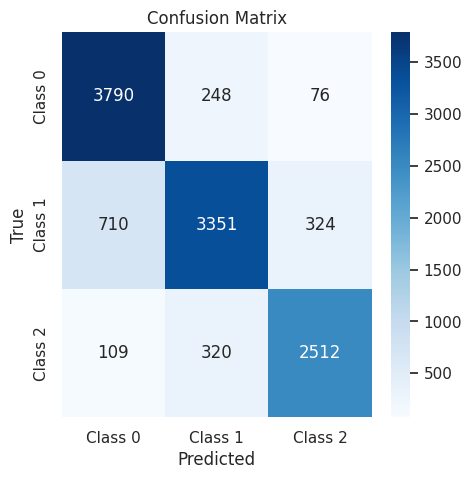

In [ ]:
resnet_model_withlaplacian = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_laplacian_encoding=True)
initialize_weights(resnet_model_withlaplacian)

laplacian_results_50 = resnet_model_withlaplacian.train_model(train_dataset_50, validation_ratio, learning_rate, batch_size, epochs)
laplacian_test_results[50] = resnet_model_withlaplacian.test_model(test_dataset_50, batch_size)

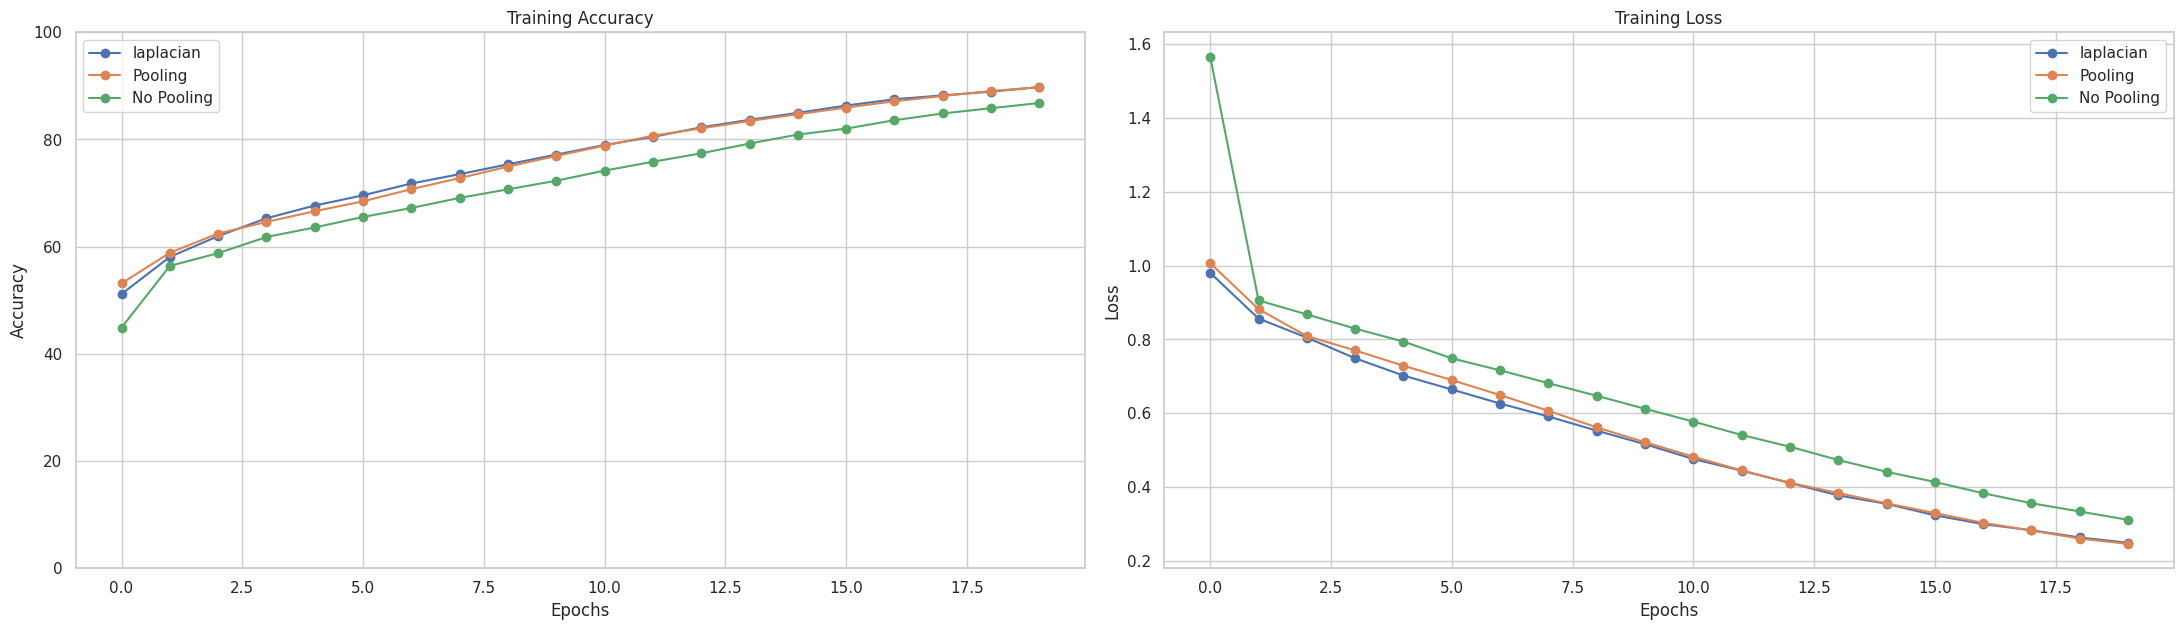

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), laplacian_results_50['train_accuracy'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_50['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_50['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), laplacian_results_50['train_loss'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_50['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_50['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dill.dump_session('session_state1.pkl')

In [ ]:
from data_loader.dataset import CustomDataset

train_set_directory, test_set_directory = create_train_test_sets(70)

train_dataset_70 = CustomDataset(root=train_set_directory)
test_dataset_70 = CustomDataset(root=test_set_directory)

Train and test directories already exist.


Epoch 1/20, Average Loss: 0.9830, Accuracy: 50.56
Epoch 2/20, Average Loss: 0.8696, Accuracy: 57.37
Epoch 3/20, Average Loss: 0.8260, Accuracy: 60.16
Epoch 4/20, Average Loss: 0.7746, Accuracy: 63.99
Epoch 5/20, Average Loss: 0.7261, Accuracy: 66.76
Epoch 6/20, Average Loss: 0.6876, Accuracy: 68.58
Epoch 7/20, Average Loss: 0.6471, Accuracy: 70.80
Epoch 8/20, Average Loss: 0.6077, Accuracy: 72.87
Epoch 9/20, Average Loss: 0.5692, Accuracy: 74.62
Epoch 10/20, Average Loss: 0.5382, Accuracy: 76.30
Epoch 11/20, Average Loss: 0.5007, Accuracy: 77.96
Epoch 12/20, Average Loss: 0.4655, Accuracy: 79.59
Epoch 13/20, Average Loss: 0.4297, Accuracy: 81.20
Epoch 14/20, Average Loss: 0.4044, Accuracy: 82.76
Epoch 15/20, Average Loss: 0.3730, Accuracy: 84.24
Epoch 16/20, Average Loss: 0.3470, Accuracy: 85.26
Epoch 17/20, Average Loss: 0.3237, Accuracy: 86.31
Epoch 18/20, Average Loss: 0.3039, Accuracy: 87.24
Epoch 19/20, Average Loss: 0.2814, Accuracy: 88.30
Epoch 20/20, Average Loss: 0.2676, Accur

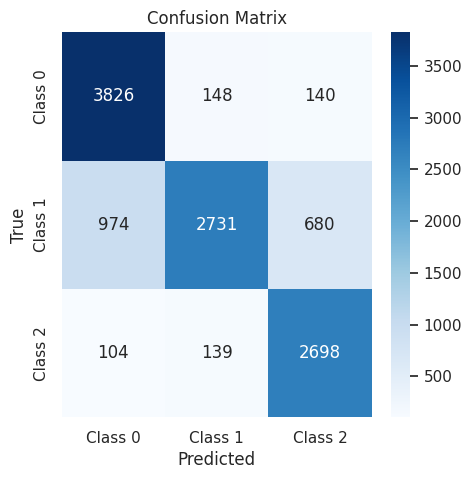

In [ ]:
resnet_model_withlaplacian = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_laplacian_encoding=True)
initialize_weights(resnet_model_withlaplacian)

laplacian_results_70 = resnet_model_withlaplacian.train_model(train_dataset_70, validation_ratio, learning_rate, batch_size, epochs)
laplacian_test_results[70] = resnet_model_withlaplacian.test_model(test_dataset_70, batch_size)

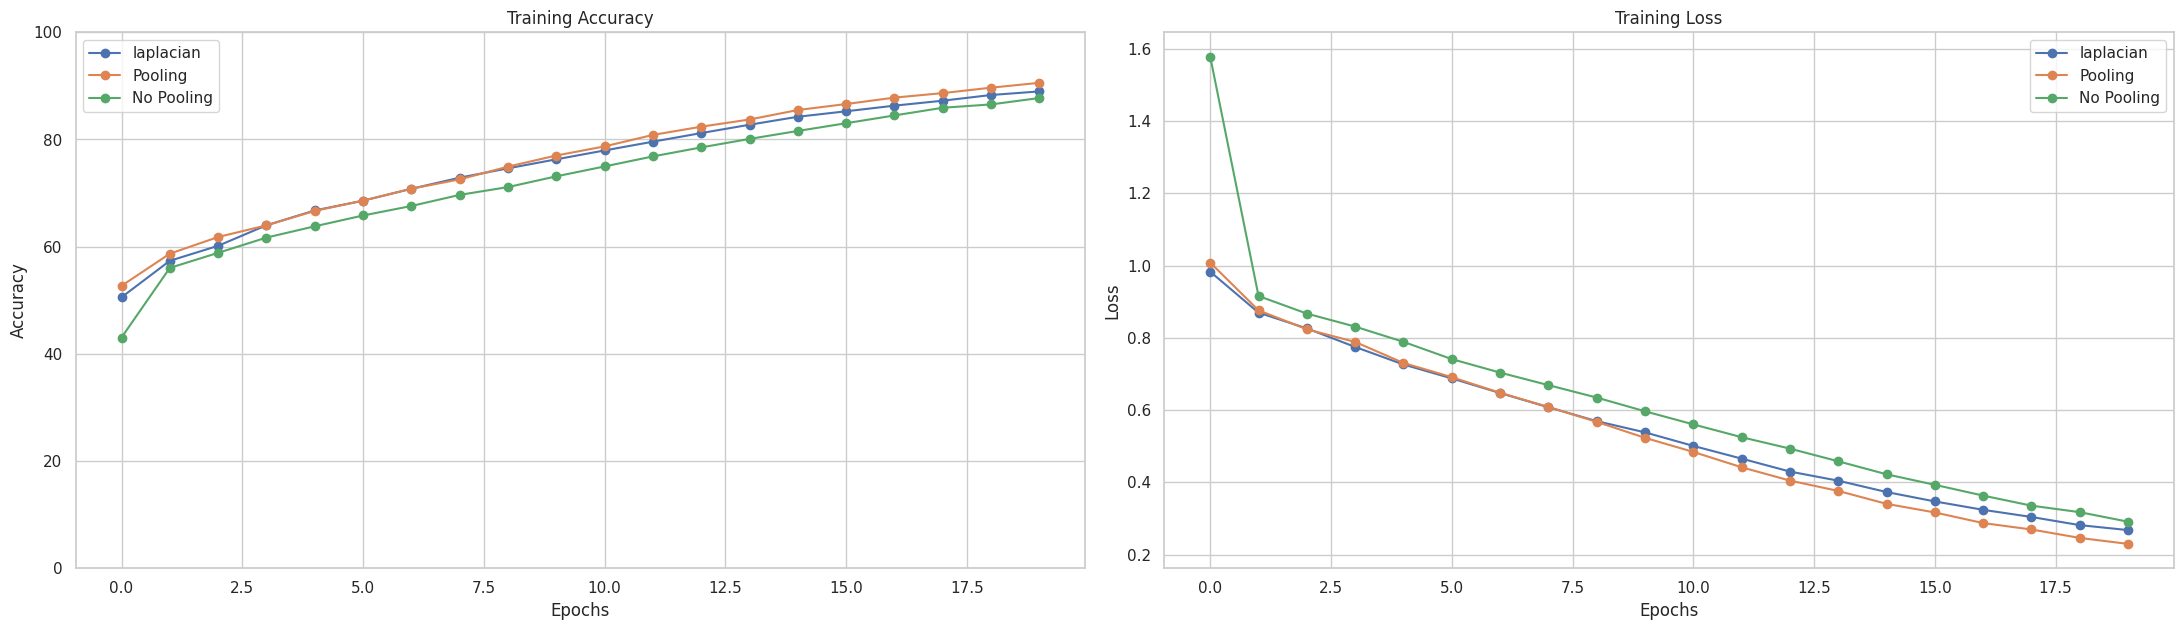

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), laplacian_results_70['train_accuracy'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_70['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_70['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), laplacian_results_70['train_loss'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_70['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_70['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dill.dump_session('session_state1.pkl')

Epoch 1/20, Average Loss: 1.0559, Accuracy: 50.02
Epoch 2/20, Average Loss: 0.8889, Accuracy: 57.91
Epoch 3/20, Average Loss: 0.8202, Accuracy: 61.85
Epoch 4/20, Average Loss: 0.7813, Accuracy: 64.50
Epoch 5/20, Average Loss: 0.7099, Accuracy: 67.71
Epoch 6/20, Average Loss: 0.6519, Accuracy: 70.87
Epoch 7/20, Average Loss: 0.5756, Accuracy: 74.31
Epoch 8/20, Average Loss: 0.4972, Accuracy: 78.25
Epoch 9/20, Average Loss: 0.4175, Accuracy: 82.03
Epoch 10/20, Average Loss: 0.3430, Accuracy: 85.58
Epoch 11/20, Average Loss: 0.2874, Accuracy: 88.20
Epoch 12/20, Average Loss: 0.2450, Accuracy: 90.03
Epoch 13/20, Average Loss: 0.2115, Accuracy: 91.52
Epoch 14/20, Average Loss: 0.1925, Accuracy: 92.47
Epoch 15/20, Average Loss: 0.1720, Accuracy: 93.22
Epoch 16/20, Average Loss: 0.1561, Accuracy: 94.04
Epoch 17/20, Average Loss: 0.1456, Accuracy: 94.41
Epoch 18/20, Average Loss: 0.1331, Accuracy: 95.04
Epoch 19/20, Average Loss: 0.1280, Accuracy: 95.17
Epoch 20/20, Average Loss: 0.1144, Accur

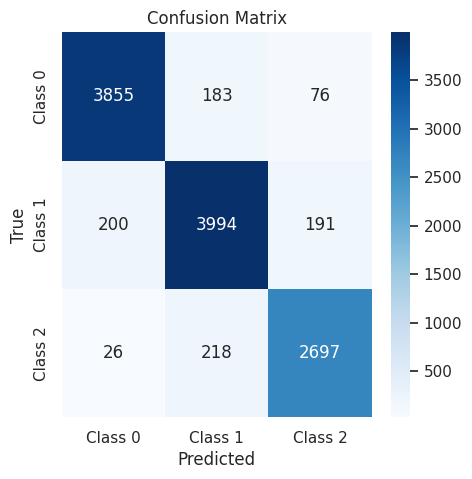

In [ ]:
#FOURIER BEFORE POOLING
learning_rate = 0.001
batch_size = 32
epochs = 20

resnet_model_withfourier = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_fourier_encoding=True)
initialize_weights(resnet_model_withfourier)
fourier_results_10 = resnet_model_withfourier.train_model(train_dataset_10, validation_ratio, learning_rate, batch_size, epochs)
fourier_test_results = {}
fourier_test_results[10] = resnet_model_withfourier.test_model(test_dataset_10, batch_size)

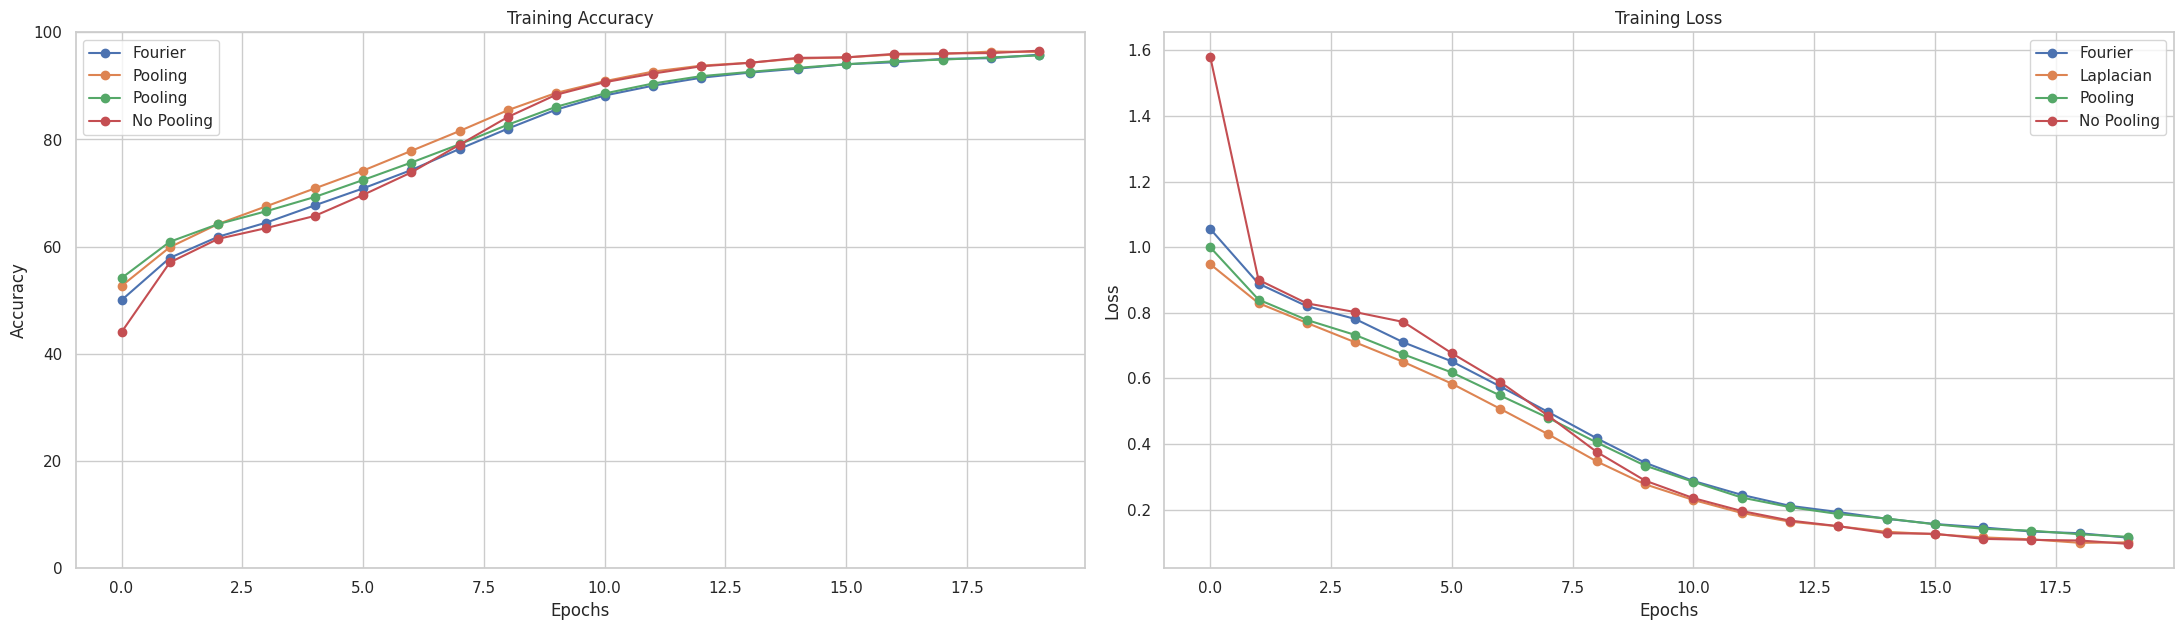

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), fourier_results_10['train_accuracy'], label='Fourier', marker='o')
plt.plot(range(epochs), laplacian_results_10['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), pooling_results_10['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_10['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), fourier_results_10['train_loss'], label='Fourier', marker='o')
plt.plot(range(epochs), laplacian_results_10['train_loss'], label='Laplacian', marker='o')
plt.plot(range(epochs), pooling_results_10['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_10['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20, Average Loss: 1.0729, Accuracy: 50.21
Epoch 2/20, Average Loss: 0.8878, Accuracy: 57.97
Epoch 3/20, Average Loss: 0.8376, Accuracy: 61.32
Epoch 4/20, Average Loss: 0.7950, Accuracy: 63.61
Epoch 5/20, Average Loss: 0.7521, Accuracy: 65.95
Epoch 6/20, Average Loss: 0.6995, Accuracy: 68.46
Epoch 7/20, Average Loss: 0.6579, Accuracy: 70.50
Epoch 8/20, Average Loss: 0.6168, Accuracy: 72.58
Epoch 9/20, Average Loss: 0.5745, Accuracy: 74.57
Epoch 10/20, Average Loss: 0.5328, Accuracy: 76.73
Epoch 11/20, Average Loss: 0.4955, Accuracy: 78.18
Epoch 12/20, Average Loss: 0.4608, Accuracy: 80.09
Epoch 13/20, Average Loss: 0.4216, Accuracy: 81.80
Epoch 14/20, Average Loss: 0.3880, Accuracy: 83.42
Epoch 15/20, Average Loss: 0.3648, Accuracy: 84.48
Epoch 16/20, Average Loss: 0.3352, Accuracy: 85.66
Epoch 17/20, Average Loss: 0.3110, Accuracy: 86.69
Epoch 18/20, Average Loss: 0.2927, Accuracy: 87.72
Epoch 19/20, Average Loss: 0.2666, Accuracy: 89.12
Epoch 20/20, Average Loss: 0.2503, Accur

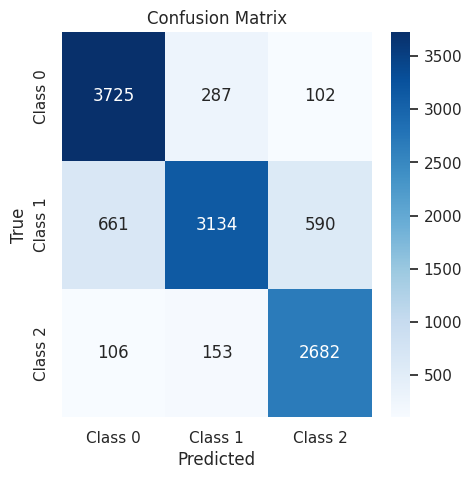

In [ ]:
resnet_model_withfourier = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_fourier_encoding=True)
initialize_weights(resnet_model_withfourier)

fourier_results_30 = resnet_model_withfourier.train_model(train_dataset_30, validation_ratio, learning_rate, batch_size, epochs)
fourier_test_results[30] = resnet_model_withfourier.test_model(test_dataset_30, batch_size)

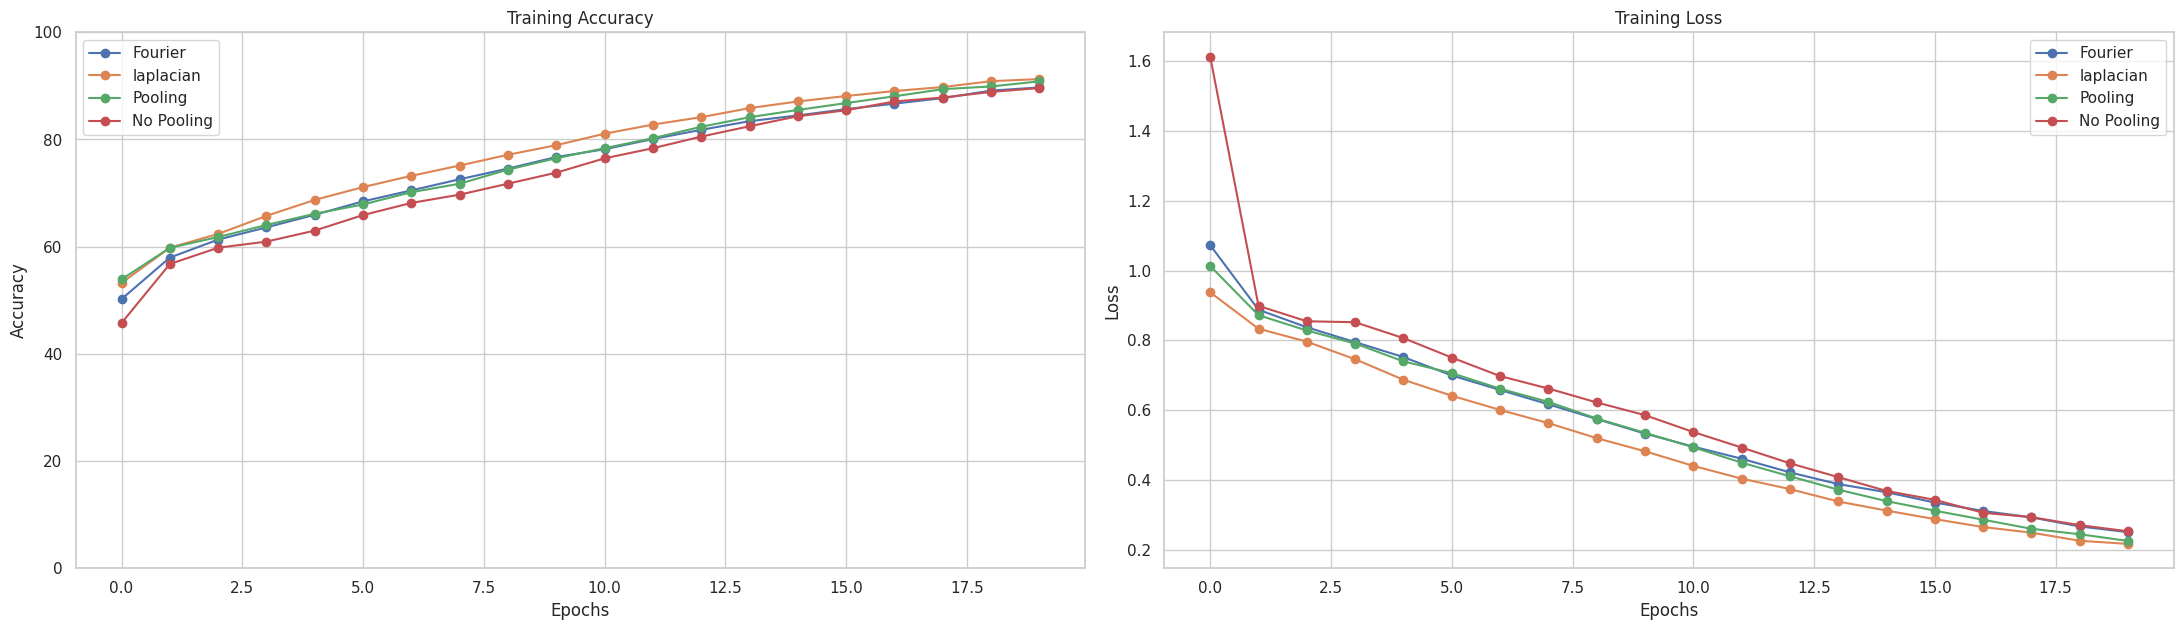

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), fourier_results_30['train_accuracy'], label='Fourier', marker='o')
plt.plot(range(epochs), laplacian_results_30['train_accuracy'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_30['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_30['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), fourier_results_30['train_loss'], label='Fourier', marker='o')
plt.plot(range(epochs), laplacian_results_30['train_loss'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_30['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_30['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dill.dump_session('session_state1.pkl')

Epoch 1/20, Average Loss: 1.0820, Accuracy: 49.73
Epoch 2/20, Average Loss: 0.8970, Accuracy: 57.22
Epoch 3/20, Average Loss: 0.8423, Accuracy: 60.42
Epoch 4/20, Average Loss: 0.7905, Accuracy: 63.42
Epoch 5/20, Average Loss: 0.7430, Accuracy: 65.73
Epoch 6/20, Average Loss: 0.7015, Accuracy: 68.20
Epoch 7/20, Average Loss: 0.6578, Accuracy: 70.13
Epoch 8/20, Average Loss: 0.6225, Accuracy: 72.03
Epoch 9/20, Average Loss: 0.5815, Accuracy: 74.15
Epoch 10/20, Average Loss: 0.5448, Accuracy: 75.94
Epoch 11/20, Average Loss: 0.5096, Accuracy: 77.87
Epoch 12/20, Average Loss: 0.4756, Accuracy: 79.29
Epoch 13/20, Average Loss: 0.4400, Accuracy: 80.87
Epoch 14/20, Average Loss: 0.4069, Accuracy: 82.50
Epoch 15/20, Average Loss: 0.3792, Accuracy: 83.74
Epoch 16/20, Average Loss: 0.3533, Accuracy: 84.95
Epoch 17/20, Average Loss: 0.3242, Accuracy: 86.28
Epoch 18/20, Average Loss: 0.3004, Accuracy: 87.33
Epoch 19/20, Average Loss: 0.2789, Accuracy: 88.33
Epoch 20/20, Average Loss: 0.2618, Accur

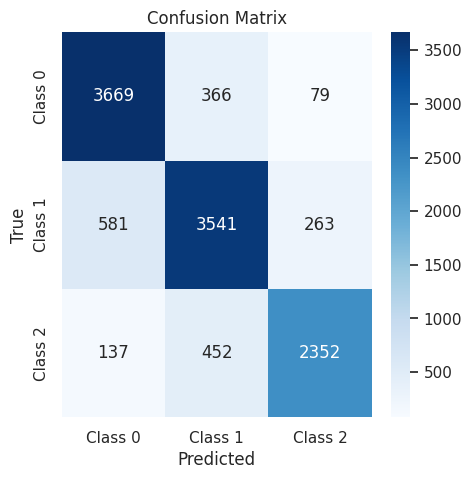

In [ ]:
resnet_model_withfourier = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_fourier_encoding=True)
initialize_weights(resnet_model_withfourier)

fourier_results_50 = resnet_model_withfourier.train_model(train_dataset_50, validation_ratio, learning_rate, batch_size, epochs)
fourier_test_results[50] = resnet_model_withfourier.test_model(test_dataset_50, batch_size)

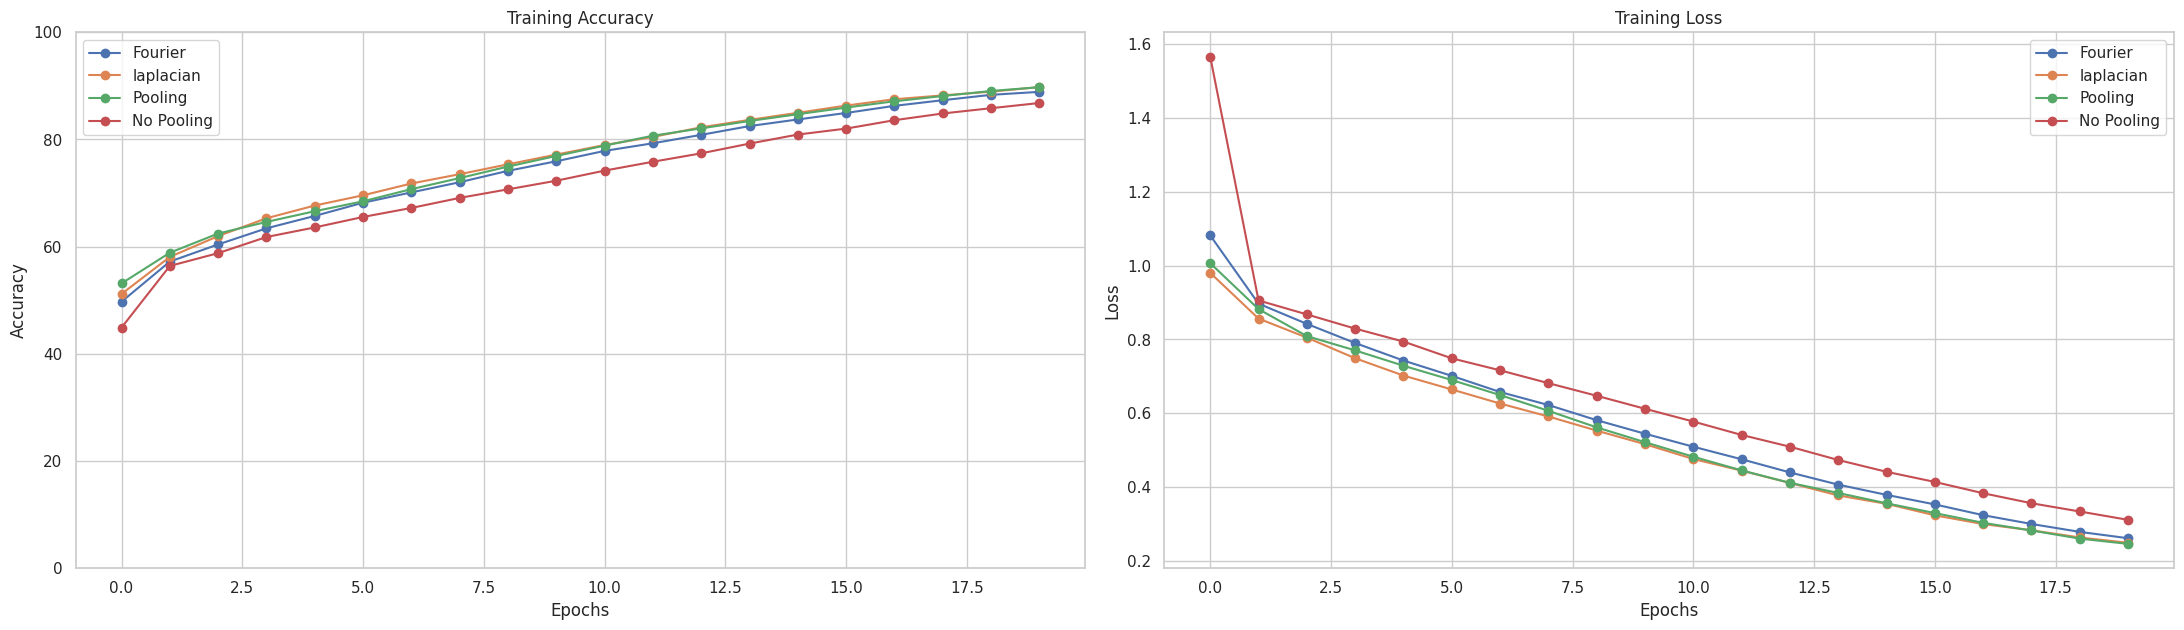

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), fourier_results_50['train_accuracy'], label='Fourier', marker='o')
plt.plot(range(epochs), laplacian_results_50['train_accuracy'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_50['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_50['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), fourier_results_50['train_loss'], label='Fourier', marker='o')
plt.plot(range(epochs), laplacian_results_50['train_loss'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_50['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_50['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
resnet_model_withfourier = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_fourier_encoding=True)
initialize_weights(resnet_model_withfourier)

fourier_results_70 = resnet_model_withfourier.train_model(train_dataset_70, validation_ratio, learning_rate, batch_size, epochs)
fourier_test_results[70] = resnet_model_withfourier.test_model(test_dataset_70, batch_size)

Epoch 1/20, Average Loss: 1.0632, Accuracy: 50.15
Epoch 2/20, Average Loss: 0.9021, Accuracy: 57.48
Epoch 3/20, Average Loss: 0.8509, Accuracy: 60.64
Epoch 4/20, Average Loss: 0.8073, Accuracy: 62.84
Epoch 5/20, Average Loss: 0.7638, Accuracy: 65.20
Epoch 6/20, Average Loss: 0.7193, Accuracy: 67.27
Epoch 7/20, Average Loss: 0.6799, Accuracy: 68.91
Epoch 8/20, Average Loss: 0.6396, Accuracy: 71.06
Epoch 9/20, Average Loss: 0.6027, Accuracy: 72.74
Epoch 10/20, Average Loss: 0.5633, Accuracy: 75.02
Epoch 11/20, Average Loss: 0.5282, Accuracy: 76.66
Epoch 12/20, Average Loss: 0.4917, Accuracy: 78.54
Epoch 13/20, Average Loss: 0.4574, Accuracy: 80.12
Epoch 14/20, Average Loss: 0.4259, Accuracy: 81.50
Epoch 15/20, Average Loss: 0.3980, Accuracy: 82.91
Epoch 16/20, Average Loss: 0.3652, Accuracy: 84.25


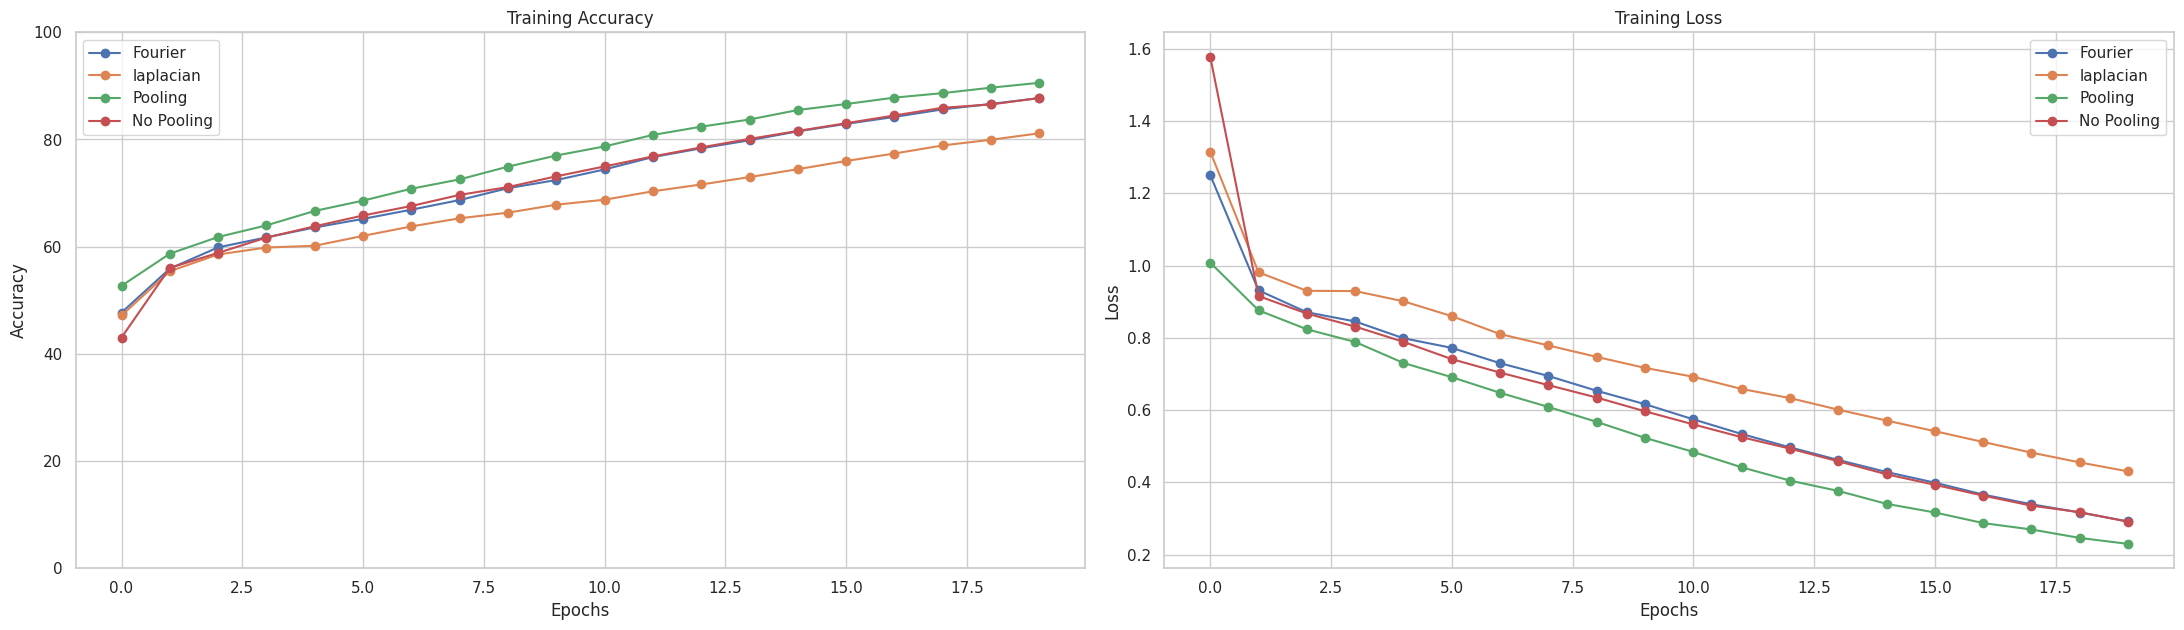

In [ ]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(22, 12))
# Plot Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), fourier_results_70['train_accuracy'], label='Fourier', marker='o')
plt.plot(range(epochs), laplacian_results_70['train_accuracy'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_70['train_accuracy'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_70['train_accuracy'], label='No Pooling', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

# Plot Training Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), fourier_results_70['train_loss'], label='Fourier', marker='o')
plt.plot(range(epochs), laplacian_results_70['train_loss'], label='laplacian', marker='o')
plt.plot(range(epochs), pooling_results_70['train_loss'], label='Pooling', marker='o')
plt.plot(range(epochs), no_pooling_results_70['train_loss'], label='No Pooling', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dill.dump_session('session_state1.pkl')

In [11]:
import dill
dill.load_session('session_state.pkl')

In [20]:
resnet_model_withzernike = ResNetEncoder(BasicBlock, [2, 2, 2, 2, 2], num_classes=3, use_zernike_encoding=True)
initialize_weights(resnet_model_withzernike)
zernike_results_10 = resnet_model_withzernike.train_model(train_dataset_10, learning_rate, batch_size, epochs)
zernike_test_results = {}
zernike_test_results[10] = resnet_model_withzernike.test_model(test_dataset_10, batch_size)

Size of x along dimension 1: 1024
Size of zernike_features along dimension 1: 1024


RuntimeError: Sizes of tensors must match except in dimension 2. Got 1 and 4 (The offending index is 0)

In [18]:
print(resnet_model_withzernike)

ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running